# Assignment 3: Logistic Regression


## Problem statement

You are working as a Data Scientist at a Finance company which proposes home loans. When a customer applies for a home loan, the company studies his demand to decide whether he/she is eligible or not.

Your boss asks you to develop a decision-aid tool to automate the loan eligibility process. The tool is supposed to be given as input the information provided by the customer while filling his/her online loan application form. These information include customer's personal citeria such as Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, etc... To develop the algorithm/model to be applied in the tool, you are given a data set containing historical information about applicants (**features**) as well as their loan status (**output** given as binary variable indicating whether or not a the loan was approved).

![image.png](attachment:image.png)

1- Load data

In [166]:
# imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# show plots in the notebook
%matplotlib inline

In [167]:
df = pd.read_csv("loan_prediction.csv")
df.shape

(614, 13)

In [168]:
assert df.shape == (614, 13)

In [169]:
df.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

2- Remove the "Loan_ID" column, and then transform the "Loan_Status" feature from categorical into numerical values (Y ==> 1, N ==> 0)

In [170]:
df = df.drop('Loan_ID', axis=1)
dummy = pd.get_dummies(df['Loan_Status'])
df = pd.concat((df, dummy), axis=1)
df = df.drop(['Loan_Status'], axis=1)
df = df.drop(['N'], axis=1)
df = df.rename(columns={'Y':'Loan_Status'})


In [171]:
assert df.shape == (614, 12); assert df["Loan_Status"].dtype != 'O'

## Data Exploration

3- Build a dataframe named `stats` displaying information about df columns. The index is the columns names and the columns are the following :

* `type` : type of the column
* `# null` : number of null values
* `# unique` : number of unique values
* `unique values` : unique values, concatenated as one text separated with ` - `. If the number of unique values is greater than equal 10 (>= 10), print only the the first *20* characters followed by `...`

`stats` would look like this (only the last rows are displayed)

![](img/stats.png)

In [172]:
index = []
data = []
col = ["type", "# null", "# unique", "unique values"]

for i in df.columns :
    index.append(i)
    data.append([df[i].dtypes, 
                 df[i].isnull().sum(), 
                 df[i].nunique(),
                ("-".join([str(element) for element in df[i].ffill().unique()]))[0:20] + "..." if df[i].nunique() >= 10
                 else ("-".join([str(element) for element in df[i].ffill().unique()])) ])

In [177]:
stats = pd.DataFrame(data,columns = col, index = index)
stats

type  # null  # unique            unique values
Gender              object      13         2              Male-Female
Married             object       3         2                   No-Yes
Dependents          object      15         4                 0-1-2-3+
Education           object       0         2    Graduate-Not Graduate
Self_Employed       object      32         2                   No-Yes
ApplicantIncome      int64       0       505  5849-4583-3000-2583-...
CoapplicantIncome  float64       0       287  0.0-1508.0-2358.0-41...
LoanAmount         float64      22       203  nan-128.0-66.0-120.0...
Loan_Amount_Term   float64      14        10  360.0-120.0-240.0-18...
Credit_History     float64      50         2                  1.0-0.0
Property_Area       object       0         3    Urban-Rural-Semiurban
Loan_Status          uint8       0         2                      1-0

4- Fill the null values in the column **[Married]** by the most frequent one (which is "Yes"). Then, remove all the rows containing at least one NullValue.

In [178]:
df['Married'].fillna("Yes", inplace=True)
df = df.dropna()
print(df.shape)

(480, 12)


In [179]:
assert df.isnull().sum().sum() == 0

# Data Visualization

5-1- Plot a **bar plot** of the column **Loan_Status** (% of each class). 

<AxesSubplot:>

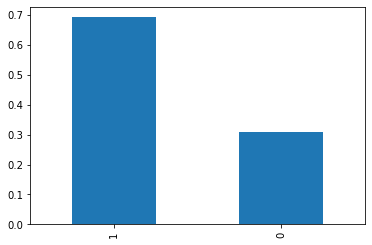

In [180]:
df['Loan_Status'].value_counts(normalize=True).plot.bar()

5-2- How many approved and non approved loans are there ? How much accuracy can you get if prediction is always equal to "*1*" ?

In [181]:
df['Loan_Status'].value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [182]:
df['Loan_Status'].value_counts(normalize=True) #0.691667


1    0.691667
0    0.308333
Name: Loan_Status, dtype: float64

6-1- Create a function to be named **make_bar_plot**, which takes two parameters as input: a dataframe df (parameter 1) and a column name (parameter 2). The function must output a borplot of the approval rate `Loan_Status` by value of the column.

Calling `make_bar_plot` on `Property_Area` should look like this

![](img/bar_plot.png)

In [183]:
def make_bar_plot(df, column):
    column = pd.crosstab(df[column],df['Loan_Status'])
    column.div(column.sum(1).astype(float), axis=0).plot(kind='barh', stacked=False)
    plt.show()
   

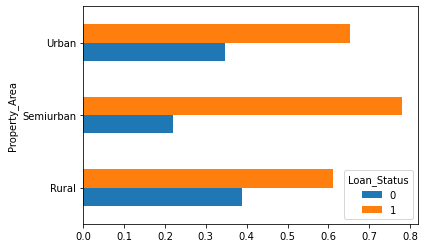

In [184]:
make_bar_plot(df, 'Property_Area')

6-2- Create a function to be named **make_box_plot**, which takes two parameters as input: a dataframe df (parameter 1) and a column name (parameter 2). The function must output a boxplot of the distribution of the column by `Loan_Status`.

Calling `make_box_plot` on `ApplicantIncome` should look like this

![](img/box_plot.png)

In [185]:
def make_box_plot(df, column):  
    df.boxplot(column, by = 'Loan_Status') 
    plt.suptitle('Boxplot grouped by Loan_Status')

In [186]:
make_box_plot(df, 'ApplicantIncome')

6-3- Loop through df columns, except for the target and make a plot depending:

* if the column is numeric, call `make_box_plot`
* else, call `make_bar_plot`

****************** Gender *******************


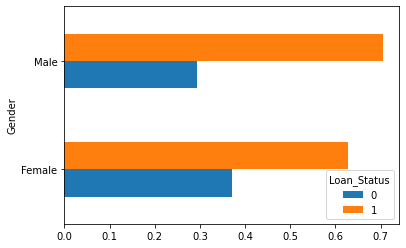

****************** Married *******************


****************** Dependents *******************


****************** Education *******************


****************** Self_Employed *******************


****************** Property_Area *******************


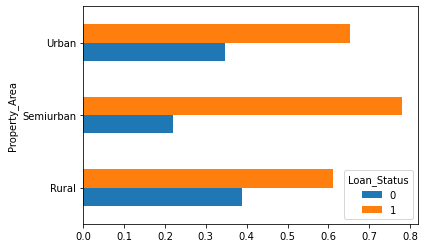

****************** ApplicantIncome *******************
****************** CoapplicantIncome *******************
****************** LoanAmount *******************
****************** Loan_Amount_Term *******************
****************** Credit_History *******************


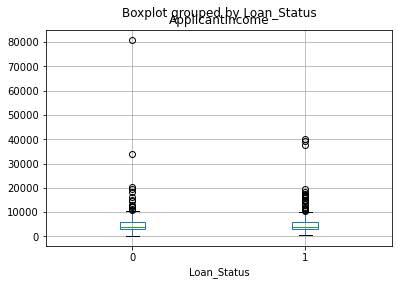

In [187]:
from pandas.api.types import is_numeric_dtype

for col in df:
    if col != "Loan_Status":
        if df[col].dtype == 'object':
            print(f'****************** {col} *******************')
            make_bar_plot(df,col)
            
for col in df:
    if col != "Loan_Status":
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            print(f'****************** {col} *******************')
            make_box_plot(df,col) 

# Model Training & Evaluation

7-1- Use [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) to transform `Property_Area` and `Dependents` into dummy variables

In [188]:
df = pd.get_dummies(df, columns=['Property_Area'])
df = pd.get_dummies(df, columns=['Dependents'])


print the head of df

In [189]:
df.head()

Gender Married     Education Self_Employed  ApplicantIncome  \
1   Male     Yes      Graduate            No             4583   
2   Male     Yes      Graduate           Yes             3000   
3   Male     Yes  Not Graduate            No             2583   
4   Male      No      Graduate            No             6000   
5   Male     Yes      Graduate           Yes             5417   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   
5             4196.0       267.0             360.0             1.0   

   Loan_Status  Property_Area_Rural  Property_Area_Semiurban  \
1            0                    1                        0   
2            1                    0                        0   
3            1                    0                        0   
4            1                    0                        0   
5            1                    0                        0   

   Property_Area_Urban  Dependents_0  Dependents_1  Dependents_2  \
1                    0             0             1             0   
2                    1             1             0             0   
3                    1             1             0             0   
4                    1             1             0             0   
5                    1             0             0             1   

   Dependents_3+  
1              0  
2              0  
3              0  
4              0  
5              0

In [190]:
assert df.shape == (480, 17)

7-2- Use `pandas.Categorical` (as seen in *Titanic* notebook) to transform the remaining text columns of df into numerical ones

In [191]:
for col in df.columns: 
    if df[col].dtype == 'object':
        df[col] = pd.Categorical(df[col]).codes

Print the head of df

In [192]:
df.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
1       1        1          0              0             4583   
2       1        1          0              1             3000   
3       1        1          1              0             2583   
4       1        0          0              0             6000   
5       1        1          0              1             5417   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   
5             4196.0       267.0             360.0             1.0   

   Loan_Status  Property_Area_Rural  Property_Area_Semiurban  \
1            0                    1                        0   
2            1                    0                        0   
3            1                    0                        0   
4            1                    0                        0   
5            1                    0                        0   

   Property_Area_Urban  Dependents_0  Dependents_1  Dependents_2  \
1                    0             0             1             0   
2                    1             1             0             0   
3                    1             1             0             0   
4                    1             1             0             0   
5                    1             0             0             1   

   Dependents_3+  
1              0  
2              0  
3              0  
4              0  
5              0

In [193]:
assert 'object' not in [df[f].dtype for f in df.columns]

8-1 Load the target variable "Loan_Status" into a dataframe and call it y. Then, load the features into a second dataframe and call it X. 

In [194]:
y = df['Loan_Status']
X = df.drop('Loan_Status', axis=1)
print (X.columns)

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+'],
      dtype='object')


8-2 Split the data set into a training set and a test set. Set: test_size=0.3, random_state=123

In [195]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print ("train shape", X_train.shape, y_train.shape)
print ("test shape", X_test.shape, y_test.shape)

train shape (336, 16) (336,)
test shape (144, 16) (144,)


8-3- Fit a logistic model to the training set, and then report the training and testing accuracies

In [196]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

train accuracy = 0.7976190476190477
test accuracy = 0.7986111111111112


9- Print the confusion matrix and compute the **precision** for class **0**, **recall** for class **1** using the formulas learned in class (you should not use metrics.classification_report)

In [197]:
from sklearn import metrics

y_pred = clf.predict(X_test)
print (metrics.confusion_matrix(y_test, y_pred))


[[22 25]
 [ 4 93]]


In [198]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

precision_0 = precision_score(y_test,y_pred)
recall_1 = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred) 

print ('precision_0 =', precision_0)
print ('recall_1 =', recall_1)

precision_0 = 0.788135593220339
recall_1 = 0.9587628865979382


10- Use 5-fold [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) and choose `f1` for scoring. Print the mean and standard deviation of scores

In [199]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, scoring='f1', cv=5)
print (scores)
print ('scores mean =', scores.mean(), 'scores std =', scores.std())

[0.87248322 0.8590604  0.8590604  0.91549296 0.86111111]
scores mean = 0.8734416191406457 scores std = 0.02160978392490238


how is the mean `f1_score` compared to the first one with train_test_split

Looks good. It's still performing at the same range of f1 score.

In [200]:
print('f1 mean = ',f1.mean())


f1 mean =  0.8651162790697674
